In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from typing import List, Dict, Any, Tuple

In [2]:
from matplotlib import rc

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [3]:
from tqdm.notebook import tqdm, trange

In [4]:
from transformers import AutoModel

In [5]:
from sentence_transformers import SentenceTransformer
from sentence_transformers.quantization import quantize_embeddings

In [6]:
from scipy.stats import pearsonr, spearmanr

In [7]:
# use toolz to set up pipeline for the data 
from toolz import pipe, compose_left

In [8]:
# this Python module is used to convert numbers to words
import inflect

In [9]:
number_lexicalizer = inflect.engine()

# let's test the lexicalizer
number_lexicalizer.number_to_words(1099)

'one thousand and ninety-nine'

In [10]:
# embedding model
emb_model_id = "mixedbread-ai/mxbai-embed-large-v1" 
multimodal = True

In [11]:
# Parameters
emb_model_id = "sentence-transformers/all-MiniLM-L12-v2"
multimodal = False


In [12]:
# load an embedding model
if multimodal:
    # Initialize the model
    emb_model_id = "jinaai/jina-clip-v1"
    model = AutoModel.from_pretrained(emb_model_id, trust_remote_code=True)
    encode = model.encode_text

else:
    model = SentenceTransformer(emb_model_id, trust_remote_code=True)
    encode = model.encode

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [13]:
numbers_int = [i for i in range(1, 11)]
numbers_str = [str(i) for i in numbers_int]
numbers_lex = [number_lexicalizer.number_to_words(i) for i in numbers_int]
numbers_rom = [
    "i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"
]

In [14]:
embedding_dict: Dict[str, np.array] = {
    "str": encode(numbers_str),
    "lex": encode(numbers_lex),
    "rom": encode(numbers_rom)
}

In [15]:
def compute_RDM(num_representations: np.array) -> np.array:
    """
    Compute the representational dissimilarity matrix (RDM) 
    for a set of representations (for example, embeddings).
    """
    n = len(num_representations)

    RDM = np.zeros((n, n))
        
    # TODO: vectorize this
    # however using loops seems to be more readable
    for i in range(n):
        for j in range(n):
            RDM[i, j] = np.linalg.norm(
                num_representations[i] - num_representations[j]
                )

    return RDM #/ np.max(RDM)

In [16]:
def get_RDM_upper_triangle(A: np.ndarray) -> np.ndarray:
    """
    Get the upper triangle values of a 2D matrix A, excluding the diagonal.
    Return a 1D array.
    """
    # get the indices of the upper triangle, excluding the diagonal
    row_indices, col_indices = np.triu_indices(A.shape[0], k=1)

    return A[row_indices, col_indices]

In [17]:
# create a pipeline to transform a representation
transform_representation = compose_left(
    compute_RDM, 
    get_RDM_upper_triangle
)

In [18]:
# compute the correlation between the two RDMs
num_int_RDM_vec = transform_representation(numbers_int)
num_str_RDM_vec = transform_representation(embedding_dict["str"])
num_lex_RDM_vec = transform_representation(embedding_dict["lex"])
num_rom_RDM_vec = transform_representation(embedding_dict["rom"])

spearmanr(num_int_RDM_vec, num_str_RDM_vec)

SignificanceResult(statistic=np.float64(0.8715810984704312), pvalue=np.float64(6.720129399632763e-15))

In [19]:
spearmanr(num_int_RDM_vec, num_lex_RDM_vec)

SignificanceResult(statistic=np.float64(0.9080135347277539), pvalue=np.float64(7.501059745042516e-18))

In [20]:
spearmanr(num_int_RDM_vec, num_rom_RDM_vec)

SignificanceResult(statistic=np.float64(0.3542671452517364), pvalue=np.float64(0.016957439945087895))

In [21]:
def plot_correlation_scatter(x, y, x_lim, y_lim):

    fig, ax = plt.subplots(figsize=(6, 5))

    # Plot the scatter plot
    ax.scatter(x, y, color="grey", marker='o', s=8)

    # Add a correlation line
    ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='red')

    r = spearmanr(x, y).correlation
    p = spearmanr(x, y).pvalue

    # Add correlation and p-value as text
    rho = r"$\rho$"
    plt.text(0.6, 0.15, f'Spearman {rho}  = {r:.2f}\np_value = {p:.4f}', 
             transform=plt.gca().transAxes, 
             verticalalignment='top', 
             fontsize=14,
             c='red')

    ax.set_xticks(np.linspace(0, 10, 11))

    # Set the labels and title
    ax.set_xlabel('Number line distance')
    ax.set_ylabel('Embedding space distance')
    ax.set_title('Correlation between distances')
    ax.set_xlim(x_lim)
    plt.ylim(y_lim)

    # Show the plot
    #plt.grid(True, which='major', axis='x', linestyle='--') #color='blue', alpha=0.5
    plt.show()


In [22]:
# Concatenate the vectors into one large vector
concatenated_vector = np.concatenate((
     num_str_RDM_vec, 
     num_lex_RDM_vec, 
     num_rom_RDM_vec))

max_vec = np.max(concatenated_vector)
min_vec = np.min(concatenated_vector)

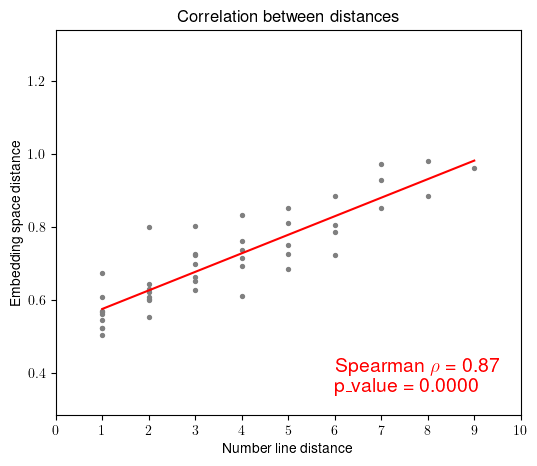

In [23]:
plot_correlation_scatter(num_int_RDM_vec, 
                         num_str_RDM_vec, 
                         x_lim=(0, 10),
                         y_lim=(min_vec - 0.15, max_vec + 0.15))

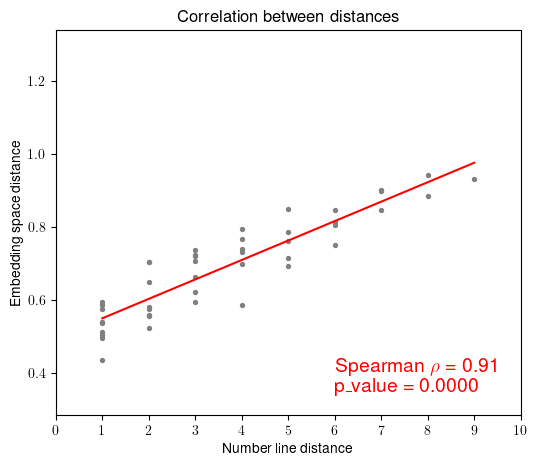

In [24]:
plot_correlation_scatter(num_int_RDM_vec, 
                         num_lex_RDM_vec, 
                         x_lim=(0, 10),
                         y_lim=(min_vec - 0.15, max_vec + 0.15))

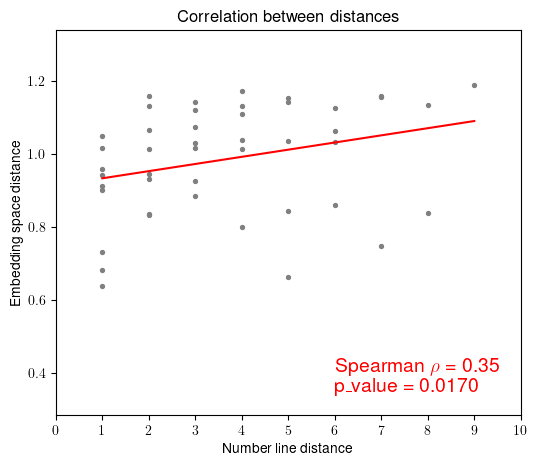

In [25]:
plot_correlation_scatter(num_int_RDM_vec, 
                         num_rom_RDM_vec, 
                         x_lim=(0, 10),
                         y_lim=(min_vec - 0.15, max_vec + 0.15))

In [26]:
def plot_RDM(repr_view: np.array, 
             labels: List[str] = None,
             title: str = None,
             with_annotations=True,
             with_ticklabels=True) -> None:
    """
    Plot a representational dissimilarity matrix (RDM).
    """
    RDM = compute_RDM(repr_view) 
    # normalize the RDM
    RDM = RDM / np.max(RDM)

    # set the diagonal to NaN
    np.fill_diagonal(RDM, np.nan)

    m = len(repr_view)/ 10

    plt.figure(figsize=(5, 5))
    sns.heatmap(
        RDM, 
        cmap='Spectral_r', 
        xticklabels=labels, 
        yticklabels=labels, 
        linewidths=0.5,
        linecolor='white',
        annot=with_annotations,
        fmt=".2f",
        cbar=False,
        annot_kws={"fontsize":9},
    ).collections[0].cmap.set_bad('0.9')

    plt.title(title)
    if with_ticklabels:
        plt.yticks(rotation=0, size=12)
        plt.xticks(rotation=0, size=12)

    else:
        plt.xticks([])
        plt.yticks([])

    plt.yticks(rotation=0, size=12)
    plt.xticks(rotation=0, size=12)
    plt.show()

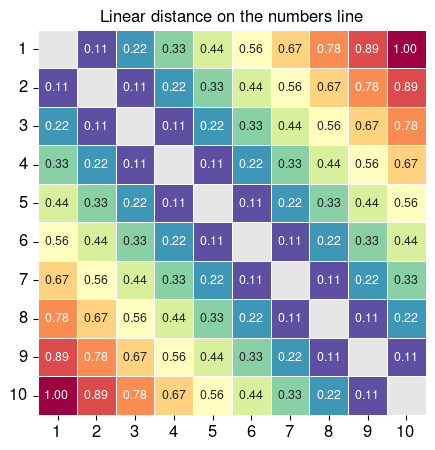

In [27]:
plot_RDM(numbers_int, 
         labels=numbers_int,
         title='Linear distance on the numbers line')

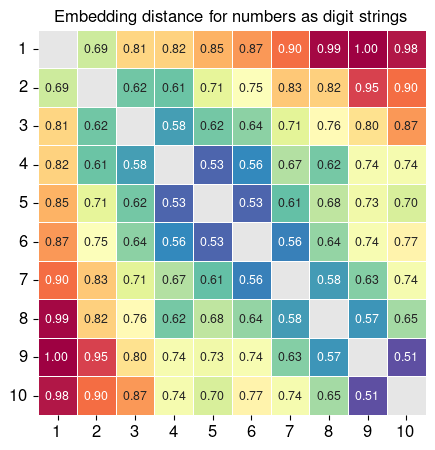

In [28]:
plot_RDM(embedding_dict["str"], 
         labels=numbers_int,
         title='Embedding distance for numbers as digit strings')

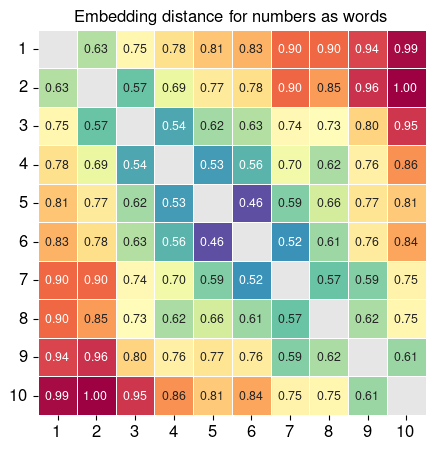

In [29]:
plot_RDM(embedding_dict["lex"], 
         labels=numbers_int,
         title='Embedding distance for numbers as words')

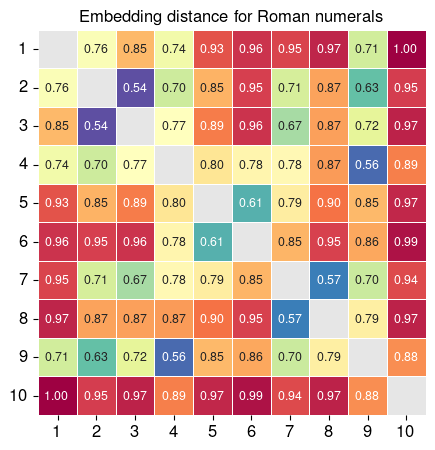

In [30]:
plot_RDM(embedding_dict["rom"], 
         labels=numbers_int,
         title='Embedding distance for Roman numerals')